# Chapter 2 Improving the Accuracy

*Editor: Weipeng Xu*

*Last modified: 01/06/2025*

*Reference: Sundnes, Joakim. Solving Ordinary Differential Equations in Python. Springer Nature, 2024.*

For the ODE system:
$$
u^{\prime}=f(t,u),\quad u(t_0) = u_0
$$
another perspective to derive the solution scheme is to integrate both sides:
$$
\int_{t_n}^{t^{n+1}}\frac{du}{dt}dt = \int_{t_n}^{t^{n+1}}f(t,u(t))dt
$$
which gives
$$
u(t_{n+1}) = u(t_n) + \int_{t_n}^{t^{n+1}}f(t,u(t))dt
$$
where the computattion of the right hand side relies on numerical integration techiniques. The classical approach is to approximate the integrand funcition $f(t,u)$ with a ploynomial, which can be further classified into two categories:

* **Multistep methods**: approximate $f(t,u)$ with a ploynomial that interpolates $f$ at **previous** time points, i.e., $f(t_{n-1},u_{n-1})$, $f(t_{n-2},u_{n-2})$...

* **Runge-Kutta (RK) methods**: approximate $f(t,u)$ with a ploynomial that interpolates $f$ at **interval** time points within $t_n<t<t_{n+1}$

## Explicit Runge-Kutta Methods

All RK methods follow the same recipe:

* Calculate one or more intermediate values (stage derivatives)

* Advance the solution using a combination of these statge derivatives

A general RK method with $s$ stages can be written as:

$$
\begin{aligned}
&k_i = f(t_n + c_i\Delta t, u_n + \Delta t\sum_{j=1}^s a_{ij}k_j),\quad i=1,\cdots,s\\
&u_{n+1} = n_n + \Delta t\sum_{i=1}^sb_ik_i
\end{aligned}
$$
where $c, b, a$ are coefficients specific to the method. Different RK methods can be uniquely determined by the number of stages $s$ and the values of the coefficients.

Some principles should be satisified for the above coefficients:

* $\sum_{i=1}^sb_i=1$ (approximmate the integral as a weighted sum)

* $c_i = \sum_{j=1}^sa_{ij}$ (not necessary but can interpretate $k_i$ approximations of $f(t,u)$ at $t_n + c_i\Delta t$)

The **Butcher tableau** provides a concise representation of any RK method, which specifies all the method coefficients:
$$
\begin{array}{c|ccc}
c_1 & a_{11} & \cdots & a_{1s} \\
\vdots & \vdots & \ddots & \vdots \\
c_s & a_{s1} & \cdots & a_{ss} \\
\hline
 & b_1 & \cdots & b_s \\
\end{array}
$$

In this chapter, we exclusively consider explicit RK methods, which means that $a_{ij}=0$ for $j\geq i$. Following are several examples:

* Forward Euler Method (1-order)

$$
\begin{array}{c|cc}
0 & 0 \\ \hline
 & 1 \\
\end{array}
$$

$$
\begin{aligned}
    &k_1 = f(t_n, u_n)\\
    &u_{n+1} = u_n + \Delta tk_1
\end{aligned}
$$

* Explicit Mid-point Method (2-order)

$$
\begin{array}{c|cc}
0   & 0 & 0 \\
\frac{1}{2}   & \frac{1}{2} & 0 \\
\hline
 & 0 & 1  \\
\end{array}
$$

$$
\begin{aligned}
&k_1 = f(t_n, u_n)\\
&k_2 = f(t_n+\frac{1}{2}\Delta t, u_n + \frac{1}{2}\Delta tk_1)\\
&u_{n+1} = u_n + \Delta tk_2
\end{aligned}
$$

* Heun's Method/Explicit Trapezoidal Method (2-order)

$$
\begin{array}{c|cc}
0   & 0 & 0 \\
1   & 1 & 0 \\
\hline
 & \frac{1}{2} & \frac{1}{2}  \\
\end{array}
$$

$$
\begin{aligned}
&k_1 = f(t_n, u_n)\\
&k_2 = f(t_n + \Delta t, u_n + \Delta tk_1)\\
&u_{n+1} = u_n + \frac{1}{2}\Delta t\left(k_1+k_2\right)
\end{aligned}
$$

* Fourth-order & Four-stage RK Method/RK4

$$
\begin{array}{c|cccc}
0   & 0 & 0 &0 & 0\\
\frac{1}{2}   & \frac{1}{2} & 0 & 0 &0 \\
\frac{1}{2}   & 0 & \frac{1}{2} & 0 & 0\\
1   & 0 & 0 & 1 & 0\\
\hline
 & \frac{1}{6} & \frac{1}{3} &\frac{1}{3} &\frac{1}{6} \\
\end{array}
$$

$$
\begin{aligned}
&k_1 = f(t_n,u_n)\\
&k_2 = f(t_n + \frac{1}{2}\Delta t, u_n + \frac{1}{2}\Delta tk_1)\\
&k_3 = f(t_n+\frac{1}{2}\Delta t, u_n+\frac{1}{2}\Delta tk_2)\\
&k_4 = f(t_n + \Delta t, u_n + \Delta tk_3)\\
& u_{n+1} = u_n + \frac{1}{6}\Delta t\left(k_1 + 2k_2 + 2k_3 + k_4\right)
\end{aligned}
$$

## A Class Hierarchy of Runge-Kutta Methods

The base class (superclass) can be written as:

In [9]:
import numpy as onp

class ODESolver:

    def __init__(self,f):
        self.model = f
        self.f = lambda t,u: onp.asarray(f(t,u), dtype=float)

    def set_initial_condition(self, u0):
        self.u0 = onp.asarray(u0, dtype=float)

    def solve(self, t_span, N):
        t0, T = t_span
        self.dt = (T-t0)/N
        self.t = onp.zeros((N+1, 1))
        self.u = onp.zeros((N+1, self.u0.size))

        msg = "Please set initial condition before calling solve"
        assert hasattr(self, "u0"), msg

        self.t[0] = t0
        self.u[0] = self.u0

        for n in range(N):
            self.n = n
            self.t[n+1] = self.t[n] + self.dt
            self.u[n+1] = self.advance()
        
        return self.t, self.u
    
    def advance(self):
        raise NotImplementedError("Advance method is not implemented in the based class")


The implementation of FE, explicit midpoint method, and RK4 can be very straightforward:

In [10]:
class ForwardEuler(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        return u[n] + dt * f(t[n], u[n])

In [11]:
class ExpliictMidpoint(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt/2., u[n] + dt/2.*k1)
        return u[n] + dt * k2

In [12]:
class Henu(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt, u[n] + dt * k1)
        return u[n] + dt/2. * (k1 + k2)

In [13]:
class RungeKutta4(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt/2., u[n] + dt/2.*k1)
        k3 = f(t[n] + dt/2., u[n] + dt/2.*k2)
        k4 = f(t[n] + dt, u[n] + dt*k3)
        return u[n] + 1/6. * dt * (k1 + 2*k2 + 2*k3 + k4)

Consider the simple ODE:
$$
\begin{aligned}
    &u^{\prime} = u\\
    &u(0) = 1
\end{aligned}
$$

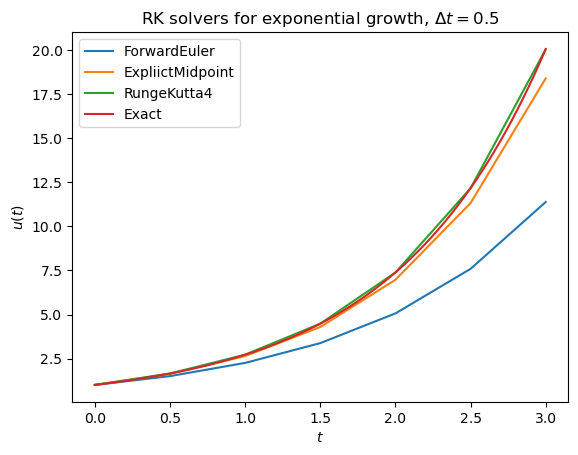

In [14]:
import numpy as onp
import matplotlib.pyplot as plt

# ODE
f = lambda t,u: u

# analytical
def exact(t):
    return onp.exp(t)

# time steps
t_span = (0, 3)
N = 6

# initialize the solver
fe = ForwardEuler(f)
em = ExpliictMidpoint(f)
he = Henu(f)
rk4 = RungeKutta4(f)

# solve & postprocess
for solver in [fe, em, rk4]:
    solver.set_initial_condition(u0=1)
    t, u = solver.solve(t_span, N)
    plt.plot(t, u , label=solver.__class__.__name__)
t_exact = onp.linspace(t_span[0], t_span[1], 301)
plt.plot(t_exact, exact(t_exact), label='Exact')
plt.title('RK solvers for exponential growth, $\\Delta t=0.5$')
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
plt.legend()
plt.show()

## Testing the Solvers

In [15]:
solver_classes = [ForwardEuler, ExpliictMidpoint, Henu, RungeKutta4]
orders = [1,2,2,4]
for solver_class, order in zip(solver_classes, orders):

    solver = solver_class(f)
    solver.set_initial_condition(u0=1.0)

    print(f'{solver_class.__name__}, order={order}')
    print(f'Time step (dt)  Error(e)      e/dt**{order}')

    N = 30
    for _ in range(10):
        t, u = solver.solve(t_span, N)
        dt = (t_span[1]-t_span[0]) / N
        e = abs(u[-1] - exact(t_span[-1])).item()
        # break if error is close to machine precision
        if e < 1e-13:
            break
        print(f'{dt:<14.7f}  {e:<12.7f}  {e/dt**order:5.4f}')
        N = N * 2

ForwardEuler, order=1
Time step (dt)  Error(e)      e/dt**1
0.1000000       2.6361347     26.3613
0.0500000       1.4063510     28.1270
0.0250000       0.7273871     29.0955
0.0125000       0.3700434     29.6035
0.0062500       0.1866483     29.8637
0.0031250       0.0937359     29.9955
0.0015625       0.0469715     30.0618
0.0007813       0.0235117     30.0950
0.0003906       0.0117624     30.1116
0.0001953       0.0058828     30.1200
ExpliictMidpoint, order=2
Time step (dt)  Error(e)      e/dt**2
0.1000000       0.0929800     9.2980
0.0500000       0.0241697     9.6679
0.0250000       0.0061593     9.8548
0.0125000       0.0015545     9.9487
0.0062500       0.0003905     9.9957
0.0031250       0.0000978     10.0192
0.0015625       0.0000245     10.0310
0.0007813       0.0000061     10.0369
0.0003906       0.0000015     10.0398
0.0001953       0.0000004     10.0413
Henu, order=2
Time step (dt)  Error(e)      e/dt**2
0.1000000       0.0929800     9.2980
0.0500000       0.0241697     9.

We can also consider an even simpler ODE:
$$
u^{\prime}(t) = f(t,u) = C
$$
with analytical solution as:
$$
u(t) = Ct + u_0
$$
where $u_0$ is the initial solution. All the methods discussed will capture this solution to machine precison.

In [16]:
# parameters
C = 0.2
u0 = 3

# ODE
f = lambda t,u: C

# analytical
def exact(t):
    return C * t + u0

# test
u0 = exact(0)
t_span = (0, 8)
N = 10
tol = 1e-14
for solver_class in solver_classes:
    solver = solver_class(f)
    solver.set_initial_condition(u0)
    t, u = solver.solve(t_span, N)
    ue = exact(t)
    max_error = abs((ue-u)).max()
    msg = f'{solver_class.__name__} failed, error={max_error}'
    assert max_error < tol, msg
print("All solvers pass the test!")

All solvers pass the test!
